In [0]:
!pip install -q keras

In [0]:
import pandas as pd
df = pd.read_csv('/content/AXISBANK.csv')

In [33]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,UTIBANK,EQ,24.70,26.7,26.70,26.70,26.7,26.70,26.70,112100,2.993070e+11,NaN,NaN,NaN
1,2000-01-04,UTIBANK,EQ,26.70,27.0,28.70,26.50,27.0,26.85,27.24,234500,6.387275e+11,NaN,NaN,NaN
2,2000-01-05,UTIBANK,EQ,26.85,26.0,27.75,25.50,26.4,26.30,26.24,170100,4.462980e+11,NaN,NaN,NaN
3,2000-01-06,UTIBANK,EQ,26.30,25.8,27.00,25.80,25.9,25.95,26.27,102100,2.681730e+11,NaN,NaN,NaN
4,2000-01-07,UTIBANK,EQ,25.95,25.0,26.00,24.25,25.0,24.80,25.04,62600,1.567220e+11,NaN,NaN,NaN


In [0]:
df1 = df.reset_index()['Close']

In [35]:
df.shape

(5041, 15)

In [36]:
df1.shape

(5041,)

In [37]:
df1

0        26.70
1        26.85
2        26.30
3        25.95
4        24.80
         ...  
5036    326.80
5037    341.40
5038    359.75
5039    368.15
5040    379.00
Name: Close, Length: 5041, dtype: float64

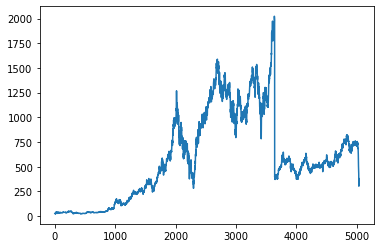

In [38]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [0]:
#data preprocessing
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [40]:
df1

array([[0.00227364],
       [0.00234859],
       [0.00207376],
       ...,
       [0.16869878],
       [0.17289626],
       [0.17831801]])

In [0]:
#train test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:]

In [42]:
print("Training size : "+ str(training_size))
print("Testing size : "+str(test_size))

Training size : 3276
Testing size : 1765


In [43]:
train_data

array([[0.00227364],
       [0.00234859],
       [0.00207376],
       ...,
       [0.7273386 ],
       [0.71806916],
       [0.71854387]])

In [44]:
test_data

array([[0.71876874],
       [0.71389666],
       [0.73553368],
       ...,
       [0.16869878],
       [0.17289626],
       [0.17831801]])

In [0]:
#convert array of values into a dataset matrix
def create_dataset(dataset, time_step):
  X_data, Y_data = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    X_data.append(a)
    Y_data.append(dataset[(i+time_step),0])
  return np.array(X_data), np.array(Y_data)

In [0]:
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [47]:
print("X_train shape : "+str(X_train.shape))
print("X_test shape : "+str(X_test.shape))
print("Y_train shape : "+str(Y_train.shape))
print("Y_test shape : "+str(Y_test.shape))

X_train shape : (3175, 100)
X_test shape : (1664, 100)
Y_train shape : (3175,)
Y_test shape : (1664,)


In [0]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [0]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
50/50 [==============================] - 5s 98ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 2/100
50/50 [==============================] - 4s 75ms/step - loss: 6.6701e-04 - val_loss: 0.0040
Epoch 3/100
50/50 [==============================] - 4s 74ms/step - loss: 6.1514e-04 - val_loss: 0.0036
Epoch 4/100
50/50 [==============================] - 4s 75ms/step - loss: 6.0467e-04 - val_loss: 0.0035
Epoch 5/100
50/50 [==============================] - 4s 75ms/step - loss: 5.6332e-04 - val_loss: 0.0034
Epoch 6/100
50/50 [==============================] - 4s 74ms/step - loss: 5.3111e-04 - val_loss: 0.0030
Epoch 7/100
50/50 [==============================] - 4s 75ms/step - loss: 5.0930e-04 - val_loss: 0.0028
Epoch 8/100
50/50 [==============================] - 4s 75ms/step - loss: 4.7647e-04 - val_loss: 0.0027
Epoch 9/100
50/50 [==============================] - 4s 75ms/step - loss: 4.4501e-04 - val_loss: 0.0026
Epoch 10/100
50/50 [==============================] - 4s 74ms/step -

In [0]:
train_predict = model.predict(X_train)
train_predict = scaler.inverse_transform(train_predict)
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

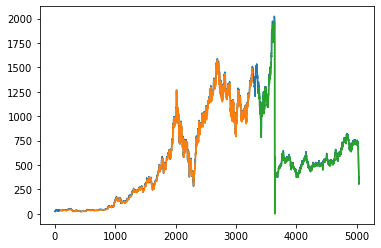

In [59]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [62]:
len(test_data)

1765

In [63]:
x_input=test_data[1665:].reshape(1,-1)
x_input.shape

(1, 100)

In [0]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [67]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.17176838]
101
1 day input [0.35556166 0.34431841 0.346667   0.3471667  0.35018989 0.36260744
 0.36308215 0.35741055 0.35476214 0.36608035 0.3648311  0.36515591
 0.3640066  0.35823506 0.36085848 0.35541175 0.35863482 0.353338
 0.34751649 0.35471217 0.34656706 0.3469918  0.34976514 0.36470618
 0.3623326  0.36153308 0.35963422 0.35998401 0.35863482 0.36028383
 0.35903458 0.35696082 0.36877873 0.36575555 0.36575555 0.36305717
 0.36717969 0.36018389 0.3503398  0.35158905 0.35096442 0.36013392
 0.35873476 0.35741055 0.36265741 0.36185789 0.35736058 0.3586598
 0.35231361 0.34751649 0.34501799 0.35021487 0.35741055 0.3588347
 0.35728563 0.3563362  0.3541625  0.35336298 0.34144513 0.34319408
 0.34621727 0.35073956 0.35718569 0.36278233 0.35925944 0.36368179
 0.3663302  0.36260744 0.35696082 0.35791025 0.35553668 0.35923446
 0.36085848 0.35143914 0.35308815 0.35341295 0.35663602 0.33737258
 0.3308265  0.33230062 0.3298271  0.32767839 0.31755946 0.30051969
 0.29842095 0.26039376 0.2731611  0.2

In [0]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [69]:
len(df1)

5041

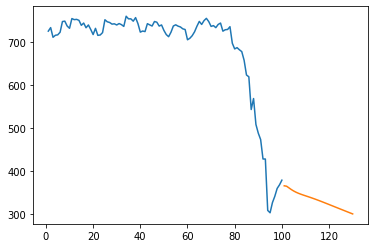

In [70]:
plt.plot(day_new,scaler.inverse_transform(df1[4941:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

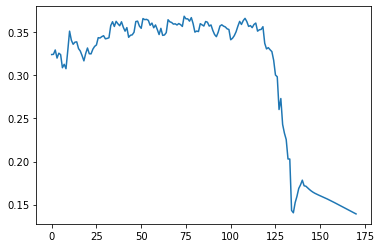

In [73]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[4900:])

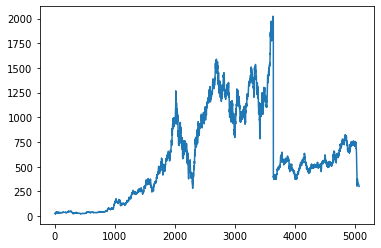

In [74]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)